Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - loss: 0.3710 - val_loss: 0.0642
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3731 - val_loss: 0.0598
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3719 - val_loss: 0.0556
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3552 - val_loss: 0.0514
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3296 - val_loss: 0.0474
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3100 - val_loss: 0.0435
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3155 - val_loss: 0.0395
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2883 - val_loss: 0.0357
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2781 - val_loss: 0.0321
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2423 - val_loss: 0.0289
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2599 - val_loss: 0.0263
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2271 - val_loss: 0.0242
Epoch 13/50

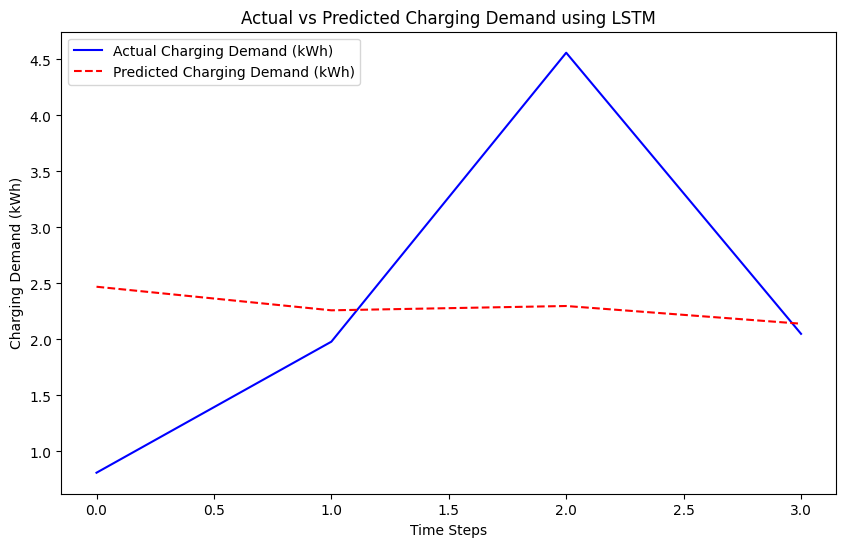

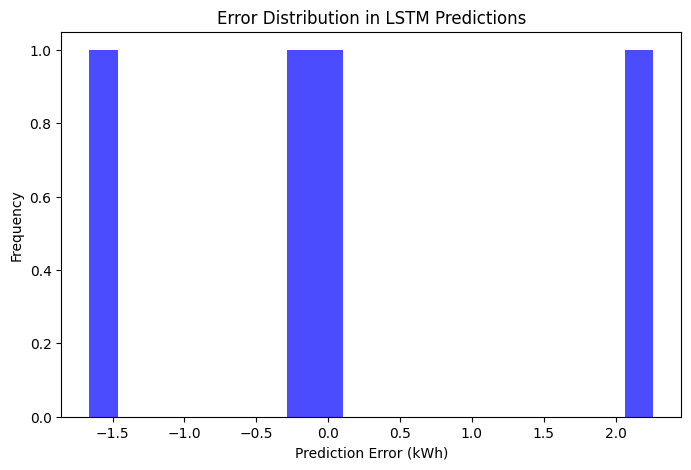

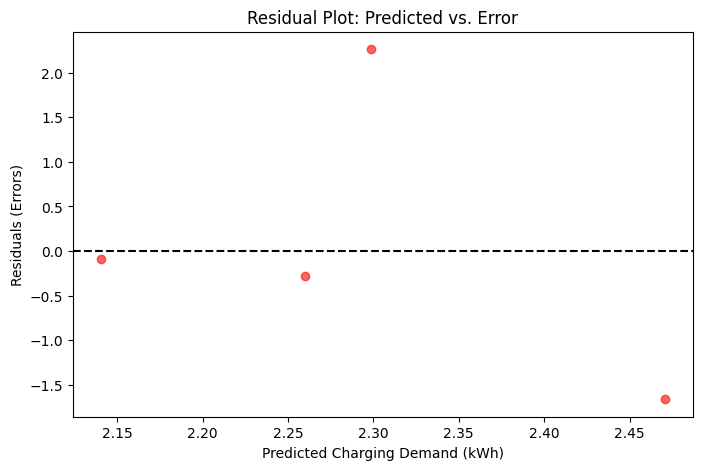

✅ LSTM model for charging demand prediction is successfully trained, evaluated, and saved.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import keras.saving

# Mount Google Drive to access datasets********************
from google.colab import drive
drive.mount('/content/drive')

# Define file paths for IoT and station datasets in local Google Drive *******************
file_path_iot = "/content/drive/MyDrive/Collab_finalprj/Smart_EV/preprocessed_iot_data.csv"
file_path_station = "/content/drive/MyDrive/Collab_finalprj/Smart_EV/station_data_dataverse.csv"

# Load datasets into pandas DataFrames
df_iot = pd.read_csv(file_path_iot)
df_station = pd.read_csv(file_path_station)

# Convert 'created' column to datetime and fix incorrect year values
df_station['created_fixed'] = df_station['created'].astype(str).apply(lambda x: x.replace('0014', '2014') if x.startswith('0014') else x)
df_station['created_parsed'] = pd.to_datetime(df_station['created_fixed'], errors='coerce')

# Drop any rows where datetime conversion failed
df_station = df_station.dropna(subset=['created_parsed'])

# Sort dataset in chronological order for time series modeling
df_station = df_station.sort_values(by='created_parsed')

# Selecting 'kwhTotal' as the target variable for prediction
df_lstm = df_station[['created_parsed', 'kwhTotal']].set_index('created_parsed')

# Normalize the target variable using MinMaxScaler for better LSTM performance
scaler = MinMaxScaler(feature_range=(0,1))
df_lstm['kwhTotal_scaled'] = scaler.fit_transform(df_lstm[['kwhTotal']])

# Function to create sequences of past observations for LSTM input
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (how many past time steps are used for prediction)
seq_length = 3  # Adjusted to avoid empty test set

# Split dataset into 70% training and 30% testing
train_size = int(len(df_lstm) * 0.7)
train_data, test_data = df_lstm['kwhTotal_scaled'].values[:train_size], df_lstm['kwhTotal_scaled'].values[train_size:]

# Create sequences for LSTM model
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input data into required LSTM format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model architecture
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(25, activation='relu', return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(10, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer for regression
])

# Compile the model using Adam optimizer and Mean Squared Error loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model with validation set
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8, callbacks=[early_stopping])

# Make predictions using the trained model
predicted_kwh = model.predict(X_test)

# Transform predictions back to original scale
predicted_kwh = scaler.inverse_transform(predicted_kwh)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE) to evaluate model performance
mse = np.mean((y_test_actual - predicted_kwh) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Plot actual vs predicted charging demand
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Charging Demand (kWh)', color='blue')
plt.plot(predicted_kwh, label='Predicted Charging Demand (kWh)', color='red', linestyle='dashed')
plt.xlabel("Time Steps")
plt.ylabel("Charging Demand (kWh)")
plt.title("Actual vs Predicted Charging Demand using LSTM")
plt.legend()
plt.show()

# Plot histogram of prediction errors
errors = y_test_actual - predicted_kwh
plt.figure(figsize=(8,5))
plt.hist(errors, bins=20, color='blue', alpha=0.7)
plt.xlabel("Prediction Error (kWh)")
plt.ylabel("Frequency")
plt.title("Error Distribution in LSTM Predictions")
plt.show()

# Plot residuals (predicted values vs errors)
plt.figure(figsize=(8,5))
plt.scatter(predicted_kwh, errors, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Predicted Charging Demand (kWh)")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot: Predicted vs. Error")
plt.show()

# Save the trained model using `.keras` format ***************************
model.save("/content/drive/MyDrive/Collab_finalprj/Smart_EV/lstm_charging_demand_model.keras")
print("✅ LSTM model for charging demand prediction is successfully trained, evaluated, and saved.")
